# Variational Autoencoders for Coniditonal Risk Factors

## Table of Contents: <a class="anchor" id="toc-bullet"></a>
* [Collecting the Data and Preprocessing](#first-bullet)
* [Risk Factor Engineering](#second-bullet)
* [Reading the Risk Factors](#third-bullet)
* [Variational Autoencoder Model](#fourth-bullet)
* [Predictions](#fifth-bullet)
* [Alpha Analysis](#sixth-bullet)

In [2]:
import numpy as np
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import quantile_transform
from scipy.stats import spearmanr
import warnings

from collections import defaultdict
from time import time


from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return
from scipy.stats import spearmanr
from time import time, strftime, localtime

Unless you install the --no-cache-dir modified version you cannot use the ticker objects like you used to!

In order to repoduce the outputs run this #pip install yfinance --upgrade --no-cache-dir

# Collecting the Data and Preprocessing <a class="anchor" id="first-bullet"></a>
* [Table of Contents](#toc-bullet)

In [3]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)
idx = pd.IndexSlice

In [ ]:
# Function to fetch NYSE tickers
def fetch_nyse_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip()
        tickers.append(ticker)
    return tickers

# Function to check if a stock is an ETF
def is_etf(ticker):
    stock = yf.Ticker(ticker)
    if 'ETF' in stock.info.get('quoteType', ''):
        return True
    return False

# Fetch NYSE tickers
nyse_tickers = fetch_nyse_tickers()

# Initialize a DataFrame to store the OHLCV data and metadata
columns = ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Sector', 'Shares Outstanding', 'Market Cap']
data = []

for ticker in nyse_tickers:
    try:
        stock = yf.Ticker(ticker)
        
        # Get historical OHLCV data
        hist = stock.history(period="max")
        hist.reset_index(inplace=True)
        hist['Ticker'] = ticker
        
        # Get metadata
        sector = stock.info.get('sector', 'N/A')
        shares_outstanding = stock.info.get('sharesOutstanding', 'N/A')
        market_cap = stock.info.get('marketCap', 'N/A')
        
        for index, row in hist.iterrows():
            data.append([row['Ticker'], row['Date'], row['Open'], row['High'], row['Low'], row['Close'], row['Volume'], sector, shares_outstanding, market_cap])
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")

# Convert to DataFrame
result_df = pd.DataFrame(data, columns=columns)

# Save to CSV
result_df.to_csv('nyse_non_etf_stocks_ohlcv_metadata.csv', index=False)


Above code is run to collect the stock information. It's already run and saved as csv file; so, from now on we just need to read the csv file rather than running that again.

In [4]:
df = pd.read_csv('nyse_non_etf_stocks_ohlcv_metadata.csv')
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222148 entries, 0 to 4222147
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Ticker              object 
 1   Date                object 
 2   Open                float64
 3   High                float64
 4   Low                 float64
 5   Close               float64
 6   Volume              int64  
 7   Sector              object 
 8   Shares Outstanding  int64  
 9   Market Cap          int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 322.1+ MB


In [5]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_convert(None).dt.date

# Convert 'Ticker' and 'Sector' to category type
df['Ticker'] = df['Ticker'].astype('category')
df['Sector'] = df['Sector'].astype('category')

# Convert numerical columns to float32
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Shares Outstanding', 'Market Cap']
df[float_columns] = df[float_columns].astype('float32')

In [6]:
missing_values = df.isnull().sum()
missing_ohlcv = df[df[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().any(axis=1)]

# Extract unique tickers with missing values
tickers_with_missing_values = missing_ohlcv['Ticker'].unique()
tickers_with_missing_values

['HUBB']
Categories (501, object): ['A', 'AAL', 'AAPL', 'ABBV', ..., 'YUM', 'ZBH', 'ZBRA', 'ZTS']

In [7]:
exclude_tickers = ['HUBB']
df = df[~df['Ticker'].isin(exclude_tickers)]

In [8]:
df['Date'] = pd.to_datetime(df.loc[:,'Date']) #so that we don't use chain-indexing with has copy issues.
df.set_index(['Date'], inplace=True)
df = df.reset_index().set_index(['Date', 'Ticker'])
df.sort_index(inplace=True)
df

Open        High         Low       Close    Volume  \
Date       Ticker                                                             
1962-01-02 AEP       0.000000    0.982233    0.959513    0.959513    5800.0   
           BA        0.194272    0.194272    0.190931    0.190931  352350.0   
           CAT       0.474928    0.479554    0.470302    0.474928  163200.0   
           CNP       0.000000    0.334535    0.332011    0.332011   13879.0   
           CVX       0.000000    0.335754    0.330448    0.335754  105840.0   
...                       ...         ...         ...         ...       ...   
2024-05-15 XYL     142.929993  143.705002  142.880005  143.294998  200678.0   
           YUM     137.139999  138.455002  137.214996  138.371399  370160.0   
           ZBH     120.580002  121.154999  120.230003  120.360001  172632.0   
           ZBRA    323.000000  325.109985  322.213013  324.290009   51175.0   
           ZTS     170.850006  174.341202  171.259995  173.964096  632893.0   

                              Sector  Shares Outstanding    Market Cap  
Date       Ticker                                                       
1962-01-02 AEP             Utilities        5.271220e+08  4.903922e+10  
           BA            Industrials        6.138840e+08  1.084488e+11  
           CAT           Industrials        4.890530e+08  1.760689e+11  
           CNP             Utilities        6.397240e+08  1.915654e+10  
           CVX                Energy        1.842970e+09  2.997022e+11  
...                              ...                 ...           ...  
2024-05-15 XYL           Industrials        2.424470e+08  3.474144e+10  
           YUM     Consumer Cyclical        2.816320e+08  3.896982e+10  
           ZBH            Healthcare        2.057280e+08  2.476142e+10  
           ZBRA           Technology        5.141940e+07  1.667480e+10  
           ZTS            Healthcare        4.562950e+08  7.937895e+10  

[4209169 rows x 8 columns]

In [9]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4209169 entries, (Timestamp('1962-01-02 00:00:00'), 'AEP') to (Timestamp('2024-05-15 00:00:00'), 'ZTS')
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   Open                4209169 non-null  float32 
 1   High                4209169 non-null  float32 
 2   Low                 4209169 non-null  float32 
 3   Close               4209169 non-null  float32 
 4   Volume              4209169 non-null  float32 
 5   Sector              4209169 non-null  category
 6   Shares Outstanding  4209169 non-null  float32 
 7   Market Cap          4209169 non-null  float32 
dtypes: category(1), float32(7)
memory usage: 133.1 MB


In [10]:
df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume',
    'Sector': 'sector',
    'Shares Outstanding': 'sharesoutstanding',
    'Market Cap': 'marketcap'
}, inplace=True)

## Sectors, Close, Volume and Returns

We'll only include the sectors with more than 50 stocks.

In [11]:
sectors = (df.sector.value_counts() > 50).index
sectors

CategoricalIndex(['Industrials', 'Financial Services', 'Technology',
                  'Healthcare', 'Consumer Cyclical', 'Consumer Defensive',
                  'Utilities', 'Real Estate', 'Energy', 'Basic Materials',
                  'Communication Services'],
                 categories=['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', ..., 'Industrials', 'Real Estate', 'Technology', 'Utilities'], ordered=False, dtype='category')

In [12]:
tickers_with_metadata = df[df.sector.isin(sectors) & 
                                 df.marketcap.notnull() &
                                 df.sharesoutstanding.notnull() & 
                                (df.sharesoutstanding > 0)]

In [13]:
close = tickers_with_metadata.close.unstack('Ticker').sort_index()
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15700 entries, 1962-01-02 to 2024-05-15
Columns: 500 entries, AEP to SOLV
dtypes: float32(500)
memory usage: 30.1 MB


In [14]:
volume = tickers_with_metadata.volume.unstack('Ticker').sort_index()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15700 entries, 1962-01-02 to 2024-05-15
Columns: 500 entries, AEP to SOLV
dtypes: float32(500)
memory usage: 30.1 MB


### Weekly Returns

In [15]:
returns = (tickers_with_metadata.close
           .unstack('Ticker')
           .resample('W-FRI').last()
           .sort_index().pct_change().iloc[1:])
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3254 entries, 1962-01-12 to 2024-05-17
Freq: W-FRI
Columns: 500 entries, AEP to SOLV
dtypes: float32(500)
memory usage: 6.2 MB


In [20]:
returns.to_csv('returns.csv')
close.to_csv('close.csv')
volume.to_csv('volume.csv')
tickers_with_metadata.to_csv('tickers_with_metadata.csv')

In [16]:
dates = tickers_with_metadata.index

# Risk Factors Engineering <a class="anchor" id="second-bullet"></a>
* [Table of Contents](#toc-bullet)

### Price Trends
* Short-Term Reversal: 1-month cumulative return
* Stock Momentum: 11-month cumulative returns ending 1-month before month end
* Momentum Change: Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
* Industry Momentum: Equal-weighted avg. industry 12-month returns
* Recent Max Return: Max daily returns from calendar month t-1
* Long-Term Reversal: Cumulative returns months t-36 to t-13.
### Liquidity Metrics
* Turnover: Avg. monthly trading volume for most recent three months scaled by number of shares; we are using the most recent no of shares from yahoo finance
* Turnover Volatility: Monthly std dev of daily share turnover
* Log Market Equity: Natural log of market cap at end of month t-1
* Dollar Volume: Natural log of trading volume time price per share from month t-2
* Amihud Illiquidity: Average of daily (absolute return / dollar volume)
### Risk Measures
* Return Volatility: Standard dev of daily returns from month t-1.
* Market Beta: Estimated market beta from weekly returns and equal weighted market returns for 3 years ending month t-1 with at least 52 weeks of returns.
* Beta Squared: Market beta squared
* Idiosyncratic return volatility: Standard dev of a regression of residuals of weekly returns on the returns of an equal weighted market index returns for the prior three years.

In [16]:
dates = returns.index

In [17]:
MONTH = 21 #21 trading days in a month

In [18]:
dates[:5], dates[-5:]

(DatetimeIndex(['1962-01-12', '1962-01-19', '1962-01-26', '1962-02-02',
                '1962-02-09'],
               dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2024-04-19', '2024-04-26', '2024-05-03', '2024-05-10',
                '2024-05-17'],
               dtype='datetime64[ns]', name='Date', freq='W-FRI'))

Stock data starts from 12th of January 1962 to 17th of May 2024!

In [43]:
mom1m = close.pct_change(periods=MONTH).resample('W-FRI').last().stack().to_frame('mom1m')
mom1m.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 869988 entries, (Timestamp('1962-02-02 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom1m   869988 non-null  float32
dtypes: float32(1)
memory usage: 6.8 MB


In [44]:
mom12m = (close
            .pct_change(periods=11 * MONTH)
            .shift(MONTH)
            .resample('W-FRI')
            .last()
            .stack()
            .to_frame('mom12m'))
mom12m.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 846189 entries, (Timestamp('1963-01-04 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'KVUE')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom12m  846189 non-null  float32
dtypes: float32(1)
memory usage: 6.6 MB


In [45]:
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom'))
chmom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 846189 entries, (Timestamp('1963-01-04 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'KVUE')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   chmom   846189 non-null  float32
dtypes: float32(1)
memory usage: 6.6 MB


In [46]:
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close')
          .join(tickers_with_metadata[['sector']]).groupby(['Date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())
indmom = (returns
          .stack()
          .to_frame('ret')
          .join(tickers_with_metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['Date', 'Ticker'])
          .loc[:, ['indmom']])
indmom.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 840048 entries, (Timestamp('1963-01-04 00:00:00'), 'AEP') to (Timestamp('2024-05-10 00:00:00'), 'VICI')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   indmom  839702 non-null  float32
dtypes: float32(1)
memory usage: 6.5 MB


In [47]:
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret'))
maxret.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 867930 entries, (Timestamp('1962-03-02 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'VLTO')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   maxret  867930 non-null  float64
dtypes: float64(1)
memory usage: 10.1 MB


In [48]:
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m'))
mom36m.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 794562 entries, (Timestamp('1965-01-08 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'ABNB')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mom36m  794562 non-null  float32
dtypes: float32(1)
memory usage: 6.2 MB


In [111]:
def calculate_turnover_ratio(group):
    group = group.reset_index(level='Ticker', drop=True)
    volume_rolling = group['volume'].rolling(3*21).mean()  # Assuming MONTH is 21 trading days
    resampled_volume = volume_rolling.resample('W-FRI').last()
    turnover = resampled_volume.div(group['sharesoutstanding'])
    return turnover

# Apply the functions to each group and concatenate the results

turn = tickers_with_metadata.groupby('Ticker').apply(calculate_turnover_ratio)



turn = turn.reset_index()
turn.columns = ['Date', 'Ticker', 'Turn'] 
##Need to have Date as the first column for later indexing operations, it becomes aligned with other risk factors


turn = turn.set_index(['Ticker', 'Date'])


turn.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4239554 entries, (Timestamp('1999-11-18 00:00:00'), 'A') to (Timestamp('2024-05-17 00:00:00'), 'ZTS')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Turn    835639 non-null  float64
dtypes: float64(1)
memory usage: 49.2 MB


In [112]:
def calculate_turnover_std(group):
    group = group.reset_index(level='Ticker', drop=True)
    turnover = group['volume'].div(group['sharesoutstanding'])
    turnover_rolling_std = turnover.rolling(21).std()  # Assuming MONTH is 21 trading days
    resampled_turnover_std = turnover_rolling_std.resample('W-FRI').last()
    return resampled_turnover_std


turn_std = tickers_with_metadata.groupby('Ticker').apply(calculate_turnover_std)
turn_std = turn_std.reset_index()
turn_std.columns = ['Date', 'Ticker', 'Turn_STD']
turn_std = turn_std.set_index(['Ticker','Date'])
turn_std.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 872151 entries, (Timestamp('1999-11-19 00:00:00'), 'A') to (Timestamp('2024-05-17 00:00:00'), 'ZTS')
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Turn_STD  870076 non-null  float64
dtypes: float64(1)
memory usage: 10.2 MB


In [51]:
close = tickers_with_metadata['close'].unstack('Ticker').ffill()

# Calculate the factor by dividing by the last available price
last_price = close.ffill().iloc[-1]
factor = close.div(last_price)

weighted_value = factor.mul(tickers_with_metadata['marketcap'].unstack('Ticker'))
weekly_weighted_value = weighted_value.resample('W-FRI').last()
mvel = np.log1p(weekly_weighted_value).stack().to_frame('mvel')

mvel.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 872151 entries, (Timestamp('1962-01-05 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mvel    872151 non-null  float32
dtypes: float32(1)
memory usage: 6.8 MB


In [52]:
dv = close.mul(volume)
dolvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack()
          .to_frame('dolvol'))
dolvol.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 867930 entries, (Timestamp('1962-03-02 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'VLTO')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dolvol  867930 non-null  float64
dtypes: float64(1)
memory usage: 10.1 MB


In [53]:
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill'))
ill.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 857425 entries, (Timestamp('1962-02-02 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ill     857425 non-null  float64
dtypes: float64(1)
memory usage: 10.0 MB


In [54]:
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol'))
retvol.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 869988 entries, (Timestamp('1962-02-02 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   retvol  869988 non-null  float64
dtypes: float64(1)
memory usage: 10.1 MB


In [55]:
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)

    return model.fit(params_only=True).params['x']
beta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta'))
beta.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 794788 entries, (Timestamp('1965-01-01 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'ABNB')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   beta    794788 non-null  float64
dtypes: float64(1)
memory usage: 9.3 MB


In [56]:
betasq = beta.beta.pow(2).to_frame('betasq')
betasq.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 794788 entries, (Timestamp('1965-01-01 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'ABNB')
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   betasq  794788 non-null  float64
dtypes: float64(1)
memory usage: 9.3 MB


In [64]:
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))
idiovol = idiovol.stack().to_frame('idiovol')
idiovol.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 794788 entries, (Timestamp('1965-01-01 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'ABNB')
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   idiovol  794788 non-null  float64
dtypes: float64(1)
memory usage: 9.3 MB


### Save Risk Factors as CSV and H5

In [52]:
mom1m.to_csv('mom1m.csv')
mom12m.to_csv('mom12m.csv')
chmom.to_csv('chmom.csv')
indmom.to_csv('indmom.csv')
maxret.to_csv('maxret.csv')
mom36m.to_csv('mom36m.csv')
turn.to_csv('turn.csv')
turn_std.to_csv('turn_std.csv')
mvel.to_csv('mvel.csv')
dolvol.to_csv('dolvol.csv')
ill.to_csv('ill.csv')
retvol.to_csv('retvol.csv')
beta.to_csv('beta.csv')
betasq.to_csv('betasq.csv')
idiovol.to_csv('idiovol.csv')

In [113]:
mom1m.index = mom1m.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in mom1m.index.levels]
)

# Save to HDF5
mom1m.squeeze().to_hdf(results_path / 'autoencoder.h5', key='factor/mom1m')

mom12m.index = mom12m.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in mom12m.index.levels]
)

# Save to HDF5
mom12m.to_hdf(results_path / 'autoencoder.h5', key='factor/mom12m')

chmom.index = chmom.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in chmom.index.levels]
)

# Save to HDF5
chmom.to_hdf(results_path / 'autoencoder.h5', key='factor/chmom')

indmom.index = indmom.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in indmom.index.levels]
)

# Save to HDF5
indmom.to_hdf(results_path / 'autoencoder.h5', key='factor/indmom')

maxret.index = maxret.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in maxret.index.levels]
)

# Save to HDF5
maxret.to_hdf(results_path / 'autoencoder.h5', key='factor/maxret')

mom36m.index = mom36m.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in mom36m.index.levels]
)

# Save to HDF5
mom36m.to_hdf(results_path / 'autoencoder.h5', key='factor/mom36m')

turn.index = turn.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in turn.index.levels]
)

# Save to HDF5
turn.to_hdf(results_path / 'autoencoder.h5', key='factor/turn')

turn_std.index = turn_std.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in turn_std.index.levels]
)

# Save to HDF5
turn_std.to_hdf(results_path / 'autoencoder.h5', key='factor/turn_std')

mvel.index = mvel.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in mvel.index.levels]
)

# Save to HDF5
mvel.to_hdf(results_path / 'autoencoder.h5', key='factor/mvel')

dolvol.index = dolvol.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in dolvol.index.levels]
)

# Save to HDF5
dolvol.to_hdf(results_path / 'autoencoder.h5', key='factor/dolvol')

ill.index = ill.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in ill.index.levels]
)

# Save to HDF5
ill.to_hdf(results_path / 'autoencoder.h5', key='factor/ill')

retvol.index = retvol.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in retvol.index.levels]
)

# Save to HDF5
retvol.to_hdf(results_path / 'autoencoder.h5', key='factor/retvol')

beta.index = beta.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in beta.index.levels]
)

# Save to HDF5
beta.to_hdf(results_path / 'autoencoder.h5', key='factor/beta')

betasq.index = betasq.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in betasq.index.levels]
)

# Save to HDF5
betasq.to_hdf(results_path / 'autoencoder.h5', key='factor/betasq')


idiovol.index = idiovol.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in idiovol.index.levels]
)

# Save to HDF5
idiovol.to_hdf(results_path / 'autoencoder.h5', key='factor/idiovol')


In [26]:
close_reset = close.reset_index()

# Save the DataFrame using fixed format
with pd.HDFStore('autoencoder.h5') as store:
    store.put('close', close_reset, format='fixed')

# Loading back the DataFrame to verify
with pd.HDFStore('autoencoder.h5') as store:
    close_loaded = store.get('close')
    close_loaded.set_index('Date', inplace=True)
    close_loaded.index = pd.to_datetime(close_loaded.index)

# Display the first few rows of the loaded DataFrame
close_loaded.head()

Ticker,AEP,BA,CAT,CNP,CVX,DIS,DTE,ED,GD,GE,...,CTVA,CARR,OTIS,ABNB,CEG,GEHC,KVUE,VLTO,GEV,SOLV
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,0.959513,0.190931,0.474928,0.332011,0.335754,0.058209,0.413492,0.255329,0.174832,0.396605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,0.957765,0.194750,0.479553,0.328767,0.334995,0.058990,0.410089,0.255329,0.180684,0.392626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,0.943783,0.192840,0.491889,0.328767,0.331964,0.058990,0.406686,0.254541,0.181415,0.387984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,0.922810,0.189022,0.496515,0.320836,0.323627,0.059185,0.398177,0.249024,0.182147,0.378035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,0.915819,0.189499,0.499599,0.317231,0.322111,0.058990,0.399028,0.250206,0.185073,0.377372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
volume_reset = volume.reset_index()

# Save the DataFrame using fixed format
with pd.HDFStore('autoencoder.h5') as store:
    store.put('volume', volume_reset, format='fixed')

In [142]:
returns_reset = close.reset_index()

# Save the DataFrame using fixed format
with pd.HDFStore('autoencoder.h5') as store:
    store.put('returns', returns_reset, format='fixed')

In [144]:
tickers_with_metadata = close.reset_index()

# Save the DataFrame using fixed format
with pd.HDFStore('autoencoder.h5') as store:
    store.put('metadata', tickers_with_metadata, format='fixed')

# Reading the Risk Factors <a class="anchor" id="third-bullet"></a>
* [Table of Contents](#toc-bullet)

In [19]:
data = returns.stack(dropna=False).to_frame('returns').loc[idx['1993':, :], :]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 819000 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   returns  678511 non-null  float32
dtypes: float32(1)
memory usage: 6.4 MB


In [21]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        print(key)
        data[key.split('/')[-1]] = store[key].squeeze()

factor/beta
factor/betasq
factor/chmom
factor/dolvol
factor/idiovol
factor/ill
factor/indmom
factor/maxret
factor/mom12m
factor/mom1m
factor/mom36m
factor/mvel
factor/retvol
factor/turn
factor/turn_std


In [22]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']
characteristics = data.drop('returns', axis=1).columns.tolist()
data['returns_fwd'] = data.returns.unstack('Ticker').shift(-1).stack()
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 819000 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2024-05-17 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   returns      678511 non-null  float32
 1   beta         641009 non-null  float64
 2   betasq       641009 non-null  float64
 3   chmom        666579 non-null  float32
 4   dolvol       676750 non-null  float64
 5   idiovol      641009 non-null  float64
 6   ill          675042 non-null  float64
 7   indmom       654934 non-null  float32
 8   maxret       676750 non-null  float64
 9   mom12m       666579 non-null  float32
 10  mom1m        677707 non-null  float32
 11  mom36m       640838 non-null  float32
 12  mvel         678743 non-null  float32
 13  retvol       677707 non-null  float64
 14  turn         652266 non-null  float64
 15  turn_std     677759 non-null  float64
 16  return

In [23]:
nobs_by_date = data.groupby(level='Date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='Date').count(),
                                 value_name='# Observations',
                                 var_name='Characteristic')

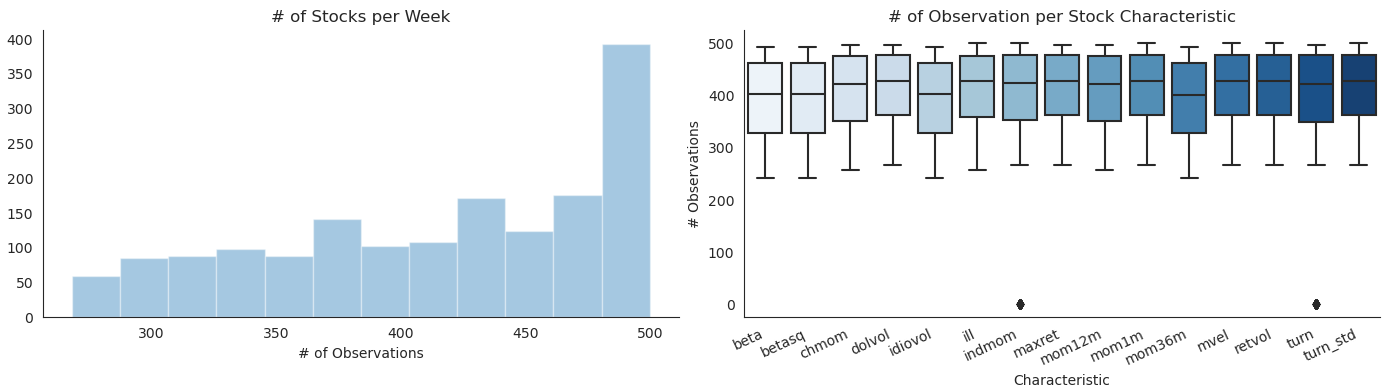

In [24]:
import warnings
warnings.filterwarnings('ignore')
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()

This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.The transformation is applied on each feature independently. First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution. The obtained values are then mapped to the desired output distribution using the associated quantile function. Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable.

In [25]:
from sklearn.preprocessing import QuantileTransformer



quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles = 200)

for column in data.columns:
    non_na_values = data[column].dropna().values.reshape(-1, 1)
    transformer = quantile_transformer.fit(non_na_values)
    transformed_values = transformer.transform(data[column].dropna().values.reshape(-1, 1)) # Apply the transformation only to non-NaN values
    data.loc[data[column].notna(), column] = transformed_values.flatten()

    
data = data.mul(2).sub(1)
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,678511.000000,641009.000000,641009.000000,666579.000000,676750.000000,641009.000000,675042.000000,654934.000000,676750.000000,666579.000000,677707.000000,640838.000000,678743.000000,677707.000000,652266.000000,677759.000000,678243.000000
mean,-0.988928,-0.976806,-0.979530,-1.010563,-0.995716,-0.999890,-11.238643,-1.011933,-1.023306,-1.034824,-0.998686,-1.012864,-0.996211,-0.988944,-1.015247,-0.987097,-1.028697
std,2.015261,1.989199,1.996631,1.984123,2.004395,1.993319,1.565655,1.995514,2.022725,1.990803,1.987370,1.985822,1.999964,1.966762,2.004097,1.992321,1.998847
min,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675,-11.398675
25%,-2.346512,-2.323913,-2.323947,-2.362803,-2.360201,-2.355644,-11.398675,-2.354090,-2.415137,-2.384599,-2.367179,-2.361005,-2.363029,-2.329870,-2.384444,-2.319521,-2.389787
50%,-0.984938,-0.947587,-0.947604,-1.032413,-1.001997,-1.011501,-11.398675,-0.999479,-1.016836,-1.035452,-1.004051,-1.008448,-1.016254,-0.973845,-1.036012,-1.004596,-1.031140
75%,0.364691,0.351543,0.351525,0.350798,0.378357,0.328528,-11.398675,0.330106,0.331835,0.297747,0.358402,0.334963,0.383542,0.340841,0.361461,0.330662,0.341411
max,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675,9.398675


In [26]:
data_fit = data.loc[idx[:'2021', :], :]
data_fit.loc[:, ['returns', 'returns_fwd']] = data_fit.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)
data_fit = data_fit.fillna(-2)
data_fit.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 757000 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AEP') to (Timestamp('2021-12-31 00:00:00', freq='W-FRI'), 'SOLV')
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   returns      757000 non-null  float32
 1   beta         757000 non-null  float64
 2   betasq       757000 non-null  float64
 3   chmom        757000 non-null  float32
 4   dolvol       757000 non-null  float64
 5   idiovol      757000 non-null  float64
 6   ill          757000 non-null  float64
 7   indmom       757000 non-null  float32
 8   maxret       757000 non-null  float64
 9   mom12m       757000 non-null  float32
 10  mom1m        757000 non-null  float32
 11  mom36m       757000 non-null  float32
 12  mvel         757000 non-null  float32
 13  retvol       757000 non-null  float64
 14  turn         757000 non-null  float64
 15  turn_std     757000 non-null  float64
 16  return

# Variational Autoencoder Model  <a class="anchor" id="fourth-bullet"></a>
* [Table of Contents](#toc-bullet)

In [27]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('Ticker'))

In [28]:
n_tickers, n_characteristics

(500, 15)

## Input Layer


In [29]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

## Stock Characteristics Layers

In [30]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

## Factor Layer

In [31]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

## Output Layer

In [32]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

In [33]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

In [34]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 500, 15)]    0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 500, 8)       128         ['input_beta[0][0]']             
                                                                                                  
 batch_norm (BatchNormalization  (None, 500, 8)      32          ['hidden_layer[0][0]']           
 )                                                                                                
                                                                                                  
 input_factor (InputLayer)      [(None, 500)]        0           []                           

In [36]:
YEAR = 52

In [37]:
np.random.seed(42)


def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='Date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

    
    
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('Ticker')
    X2_val = val.loc[:, 'returns'].unstack('Ticker')
    y_train = train.returns_fwd.unstack('Ticker')
    y_val = val.returns_fwd.unstack('Ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

In [38]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [39]:
factor_opts = [3, 4, 5]
unit_opts = [8, 16]
param_grid = list(product(unit_opts, factor_opts))
batch_size = 32
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']
start = time()

In [40]:
import numpy as np
from time import time
import pandas as pd
from scipy.stats import spearmanr

best_performance = -np.inf  # Initialize with a very low performance score
best_weights = None  # This will hold the best model weights

start = time()  # Track the start time for performance logging

for units, n_factors in param_grid:
    print(units, n_factors)
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data_fit)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data_fit,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            predictions = model.predict([X1_val, X2_val]).reshape(-1)
            result = pd.DataFrame({'y_pred': predictions, 'y_true': y_val.stack().values}, index=y_val.stack().index)
            result.replace(-2, np.nan, inplace=True)
            result.dropna(inplace=True)
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='Date').apply(lambda x: spearmanr(x.y_pred, x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0, r1.mean(), r1.std(), r1.median()])

            # Check if the current model's performance is the best, save weights if so
            if r0 > best_performance:
                best_performance = r0
                best_weights = model.get_weights()  # Save the best model weights
                print(f'New best model found: {best_performance:.2%} at epoch {epoch}')

            if epoch % 50 == 0:
                print(f'{time() - start:.2f}s | Factors: {n_factors} | Units: {units:02d} | Fold-Epoch: {fold:02d}-{epoch:03d} | '
                      f'Spearman: {r0:.2%} | Mean: {r1.mean():.2%} | Median: {r1.median():.2%}')

    scores = pd.DataFrame(scores, columns = cols)
    scores.to_hdf(results_path / 'scores.h5', key=f'{units}/{n_factors}')

# After all training, load the best weights into the model
model.set_weights(best_weights)  # Load the best weights into the model


8 3


2024-05-20 23:52:39.203684: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 2ms/step
New best model found: 5.18% at epoch 0
0.94s | Factors: 3 | Units: 08 | Fold-Epoch: 00-000 | Spearman: 5.18% | Mean: 1.99% | Median: 1.91%
2/2 [==============================] - 0s 1ms/step
11.27s | Factors: 3 | Units: 08 | Fold-Epoch: 00-050 | Spearman: -5.28% | Mean: 2.37% | Median: 0.70%
2/2 [==============================] - 0s 2ms/step
22.69s | Factors: 3 | Units: 08 | Fold-Epoch: 00-100 | Spearman: -0.05% | Mean: 2.95% | Median: 2.00%
2/2 [==============================] - 0s 1ms/step
32.81s | Factors: 3 | Units: 08 | Fold-Epoch: 00-150 | Spearman: -3.56% | Mean: 1.61% | Median: 3.11%


2/2 [==============================] - 0s 1ms/step
44.05s | Factors: 3 | Units: 08 | Fold-Epoch: 00-200 | Spearman: -3.49% | Mean: 3.07% | Median: 3.86%
2/2 [==============================] - 0s 1ms/step
New best model found: 55.47% at epoch 0
54.96s | Factors: 3 | Units: 08 | Fold-Epoch: 01-000 | Spearman: 55.47% | Mean: 14.64% | Median: 16.21%
2/2 [==============================] - 0s 1ms/step
New best model found: 55.53% at epoch 1
2/2 [==============================] - 0s 1ms/step
New best model found: 55.57% at epoch 2
2/2 [==============================] - 0s 1ms/step
66.26s | Factors: 3 | Units: 08 | Fold-Epoch: 01-050 | Spearman: 30.15% | Mean: 12.12% | Median: 11.89%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
77.31s | Factors: 3 | Units: 08 | Fold-Epoch: 01-100 | Spearman: 20.86% | Mean: 9.58% | Median: 9.85%
2/2 [==============================] - 0s 1ms/step
88.72s | Factors: 3 | Units: 08 | Fold-Epoch: 01-150 | Spearman: 16.35% | Mean: 8.76% | Median: 9.82%
2/2 [==============================] - 0s 1ms/step
99.79s | Factors: 3 | Units: 08 | Fold-Epoch: 01-200 | Spearman: 13.79% | Mean: 7.70% | Median: 9.41%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
111.48s | Factors: 3 | Units: 08 | Fold-Epoch: 02-000 | Spearman: 38.56% | Mean: 16.74% | Median: 15.84%
2/2 [==============================] - 0s 1ms/step
122.85s | Factors: 3 | Units: 08 | Fold-Epoch: 02-050 | Spearman: 26.93% | Mean: 13.23% | Median: 13.28%
2/2 [==============================] - 0s 1ms/step
134.40s | Factors: 3 | Units: 08 | Fold-Epoch: 02-100 | Spearman: 23.16% | Mean: 11.63% | Median: 12.26%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
146.08s | Factors: 3 | Units: 08 | Fold-Epoch: 02-150 | Spearman: 20.74% | Mean: 10.80% | Median: 12.00%
2/2 [==============================] - 0s 1ms/step
157.56s | Factors: 3 | Units: 08 | Fold-Epoch: 02-200 | Spearman: 19.13% | Mean: 10.10% | Median: 11.44%
2/2 [==============================] - 0s 1ms/step
169.50s | Factors: 3 | Units: 08 | Fold-Epoch: 03-000 | Spearman: 49.06% | Mean: 15.93% | Median: 16.03%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
182.27s | Factors: 3 | Units: 08 | Fold-Epoch: 03-050 | Spearman: 33.76% | Mean: 11.45% | Median: 11.96%
2/2 [==============================] - 0s 1ms/step
194.70s | Factors: 3 | Units: 08 | Fold-Epoch: 03-100 | Spearman: 29.11% | Mean: 10.15% | Median: 9.95%
2/2 [==============================] - 0s 1ms/step
206.17s | Factors: 3 | Units: 08 | Fold-Epoch: 03-150 | Spearman: 23.03% | Mean: 10.13% | Median: 11.51%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
217.57s | Factors: 3 | Units: 08 | Fold-Epoch: 03-200 | Spearman: 19.56% | Mean: 9.51% | Median: 10.47%
2/2 [==============================] - 0s 1ms/step
229.16s | Factors: 3 | Units: 08 | Fold-Epoch: 04-000 | Spearman: 22.37% | Mean: 11.99% | Median: 13.77%
2/2 [==============================] - 0s 1ms/step
240.55s | Factors: 3 | Units: 08 | Fold-Epoch: 04-050 | Spearman: 9.71% | Mean: 9.87% | Median: 9.98%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step
252.22s | Factors: 3 | Units: 08 | Fold-Epoch: 04-100 | Spearman: 5.81% | Mean: 8.87% | Median: 8.57%
2/2 [==============================] - 0s 1ms/step
263.97s | Factors: 3 | Units: 08 | Fold-Epoch: 04-150 | Spearman: 3.68% | Mean: 7.97% | Median: 5.25%
2/2 [==============================] - 0s 1ms/step
275.72s | Factors: 3 | Units: 08 | Fold-Epoch: 04-200 | Spearman: 2.35% | Mean: 7.39% | Median: 8.38%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
8 4
2/2 [==============================] - 0s 2ms/step
288.20s | Factors: 4 | Units: 08 | Fold-Epoch: 00-000 | Spearman: -9.70% | Mean: 0.44% | Median: -1.16%
2/2 [==============================] - 0s 1ms/step
298.98s | Factors: 4 | Units: 08 | Fold-Epoch: 00-050 | Spearman: 10.46% | Mean: 2.40% | Median: 1.19%
2/2 [==============================] - 0s 1ms/step
310.03s | Factors: 4 | Units: 08 | Fold-Epoch: 00-100 | Spearman: 8.97% | Mean: 5.24% | Median: 4.92%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
321.08s | Factors: 4 | Units: 08 | Fold-Epoch: 00-150 | Spearman: 4.02% | Mean: 4.97% | Median: 4.90%
2/2 [==============================] - 0s 1ms/step
332.12s | Factors: 4 | Units: 08 | Fold-Epoch: 00-200 | Spearman: 0.09% | Mean: 2.88% | Median: 2.95%
2/2 [==============================] - 0s 1ms/step
New best model found: 57.08% at epoch 0
343.31s | Factors: 4 | Units: 08 | Fold-Epoch: 01-000 | Spearman: 57.08% | Mean: 16.11% | Median: 17.23%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
354.47s | Factors: 4 | Units: 08 | Fold-Epoch: 01-050 | Spearman: 31.10% | Mean: 9.18% | Median: 10.96%
2/2 [==============================] - 0s 1ms/step
365.46s | Factors: 4 | Units: 08 | Fold-Epoch: 01-100 | Spearman: 21.00% | Mean: 7.52% | Median: 8.87%
2/2 [==============================] - 0s 1ms/step
381.19s | Factors: 4 | Units: 08 | Fold-Epoch: 01-150 | Spearman: 15.68% | Mean: 5.74% | Median: 6.88%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
392.84s | Factors: 4 | Units: 08 | Fold-Epoch: 01-200 | Spearman: 13.26% | Mean: 4.77% | Median: 5.76%
2/2 [==============================] - 0s 1ms/step
404.31s | Factors: 4 | Units: 08 | Fold-Epoch: 02-000 | Spearman: 40.35% | Mean: 16.66% | Median: 14.38%
2/2 [==============================] - 0s 2ms/step
416.06s | Factors: 4 | Units: 08 | Fold-Epoch: 02-050 | Spearman: 27.51% | Mean: 13.60% | Median: 11.79%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
429.11s | Factors: 4 | Units: 08 | Fold-Epoch: 02-100 | Spearman: 21.98% | Mean: 10.82% | Median: 9.44%
2/2 [==============================] - 0s 1ms/step
442.49s | Factors: 4 | Units: 08 | Fold-Epoch: 02-150 | Spearman: 19.45% | Mean: 10.00% | Median: 7.77%
2/2 [==============================] - 0s 1ms/step
456.78s | Factors: 4 | Units: 08 | Fold-Epoch: 02-200 | Spearman: 18.23% | Mean: 9.03% | Median: 8.17%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
469.30s | Factors: 4 | Units: 08 | Fold-Epoch: 03-000 | Spearman: 50.69% | Mean: 16.74% | Median: 17.17%
2/2 [==============================] - 0s 2ms/step
481.21s | Factors: 4 | Units: 08 | Fold-Epoch: 03-050 | Spearman: 37.20% | Mean: 10.00% | Median: 12.73%
2/2 [==============================] - 0s 1ms/step
495.64s | Factors: 4 | Units: 08 | Fold-Epoch: 03-100 | Spearman: 26.64% | Mean: 6.92% | Median: 8.57%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step
508.17s | Factors: 4 | Units: 08 | Fold-Epoch: 03-150 | Spearman: 21.15% | Mean: 5.35% | Median: 7.56%
2/2 [==============================] - 0s 2ms/step
520.18s | Factors: 4 | Units: 08 | Fold-Epoch: 03-200 | Spearman: 17.80% | Mean: 4.56% | Median: 5.26%
2/2 [==============================] - 0s 2ms/step
535.27s | Factors: 4 | Units: 08 | Fold-Epoch: 04-000 | Spearman: 26.44% | Mean: 14.28% | Median: 14.86%
2/2 [==============================] - 0s 2ms/step
548.96s | Factors: 4 | Units: 08 | Fold-Epoch: 04-050 | Spearman: 12.71% | Mean: 11.46% | Median: 12.46%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
563.16s | Factors: 4 | Units: 08 | Fold-Epoch: 04-100 | Spearman: 8.40% | Mean: 9.95% | Median: 10.36%
2/2 [==============================] - 0s 2ms/step
576.35s | Factors: 4 | Units: 08 | Fold-Epoch: 04-150 | Spearman: 5.95% | Mean: 8.76% | Median: 9.38%
2/2 [==============================] - 0s 1ms/step
589.65s | Factors: 4 | Units: 08 | Fold-Epoch: 04-200 | Spearman: 5.21% | Mean: 8.10% | Median: 5.29%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step
8 5
2/2 [==============================] - 0s 1ms/step
602.33s | Factors: 5 | Units: 08 | Fold-Epoch: 00-000 | Spearman: 7.55% | Mean: 2.57% | Median: 2.18%
2/2 [==============================] - 0s 1ms/step
613.77s | Factors: 5 | Units: 08 | Fold-Epoch: 00-050 | Spearman: -3.33% | Mean: 1.72% | Median: -0.39%
2/2 [==============================] - 0s 1ms/step
625.28s | Factors: 5 | Units: 08 | Fold-Epoch: 00-100 | Spearman: 3.71% | Mean: 4.27% | Median: 2.50%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
636.58s | Factors: 5 | Units: 08 | Fold-Epoch: 00-150 | Spearman: -1.88% | Mean: 1.78% | Median: 2.75%
2/2 [==============================] - 0s 1ms/step
648.27s | Factors: 5 | Units: 08 | Fold-Epoch: 00-200 | Spearman: -2.55% | Mean: 1.77% | Median: 2.49%
2/2 [==============================] - 0s 1ms/step
659.82s | Factors: 5 | Units: 08 | Fold-Epoch: 01-000 | Spearman: 55.90% | Mean: 15.91% | Median: 16.05%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
671.50s | Factors: 5 | Units: 08 | Fold-Epoch: 01-050 | Spearman: 31.20% | Mean: 9.18% | Median: 9.69%
2/2 [==============================] - 0s 1ms/step
682.81s | Factors: 5 | Units: 08 | Fold-Epoch: 01-100 | Spearman: 20.95% | Mean: 6.82% | Median: 8.00%
2/2 [==============================] - 0s 1ms/step
693.15s | Factors: 5 | Units: 08 | Fold-Epoch: 01-150 | Spearman: 16.13% | Mean: 5.88% | Median: 5.47%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
709.26s | Factors: 5 | Units: 08 | Fold-Epoch: 01-200 | Spearman: 14.02% | Mean: 5.42% | Median: 5.25%
2/2 [==============================] - 0s 1ms/step
720.29s | Factors: 5 | Units: 08 | Fold-Epoch: 02-000 | Spearman: 41.77% | Mean: 15.27% | Median: 15.83%
2/2 [==============================] - 0s 1ms/step
730.75s | Factors: 5 | Units: 08 | Fold-Epoch: 02-050 | Spearman: 28.97% | Mean: 13.09% | Median: 11.77%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
741.25s | Factors: 5 | Units: 08 | Fold-Epoch: 02-100 | Spearman: 22.97% | Mean: 10.86% | Median: 10.31%
2/2 [==============================] - 0s 1ms/step
751.67s | Factors: 5 | Units: 08 | Fold-Epoch: 02-150 | Spearman: 19.93% | Mean: 9.53% | Median: 9.24%
2/2 [==============================] - 0s 1ms/step
762.31s | Factors: 5 | Units: 08 | Fold-Epoch: 02-200 | Spearman: 17.68% | Mean: 8.03% | Median: 6.39%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
773.09s | Factors: 5 | Units: 08 | Fold-Epoch: 03-000 | Spearman: 52.77% | Mean: 20.42% | Median: 17.84%
2/2 [==============================] - 0s 9ms/step
784.13s | Factors: 5 | Units: 08 | Fold-Epoch: 03-050 | Spearman: 36.68% | Mean: 15.20% | Median: 14.80%
2/2 [==============================] - 0s 1ms/step
794.72s | Factors: 5 | Units: 08 | Fold-Epoch: 03-100 | Spearman: 28.04% | Mean: 11.13% | Median: 13.46%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 963us/step
805.52s | Factors: 5 | Units: 08 | Fold-Epoch: 03-150 | Spearman: 18.88% | Mean: 8.09% | Median: 11.13%
2/2 [==============================] - 0s 1ms/step
816.15s | Factors: 5 | Units: 08 | Fold-Epoch: 03-200 | Spearman: 15.88% | Mean: 6.68% | Median: 7.51%
2/2 [==============================] - 0s 1ms/step
827.16s | Factors: 5 | Units: 08 | Fold-Epoch: 04-000 | Spearman: 28.59% | Mean: 16.06% | Median: 15.33%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
838.68s | Factors: 5 | Units: 08 | Fold-Epoch: 04-050 | Spearman: 15.00% | Mean: 10.91% | Median: 10.10%
2/2 [==============================] - 0s 1ms/step
849.43s | Factors: 5 | Units: 08 | Fold-Epoch: 04-100 | Spearman: 10.02% | Mean: 8.77% | Median: 6.51%
2/2 [==============================] - 0s 1ms/step
862.18s | Factors: 5 | Units: 08 | Fold-Epoch: 04-150 | Spearman: 7.91% | Mean: 7.79% | Median: 5.16%
2/2 [==============================] - 0s 968us/step


2/2 [==============================] - 0s 1ms/step
872.93s | Factors: 5 | Units: 08 | Fold-Epoch: 04-200 | Spearman: 6.10% | Mean: 6.27% | Median: 4.29%
2/2 [==============================] - 0s 1ms/step
16 3
2/2 [==============================] - 0s 2ms/step
884.83s | Factors: 3 | Units: 16 | Fold-Epoch: 00-000 | Spearman: 2.92% | Mean: -0.52% | Median: 2.35%
2/2 [==============================] - 0s 1ms/step
897.06s | Factors: 3 | Units: 16 | Fold-Epoch: 00-050 | Spearman: -4.49% | Mean: 3.13% | Median: 2.04%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
908.66s | Factors: 3 | Units: 16 | Fold-Epoch: 00-100 | Spearman: -2.76% | Mean: 3.14% | Median: 2.04%
2/2 [==============================] - 0s 3ms/step
920.49s | Factors: 3 | Units: 16 | Fold-Epoch: 00-150 | Spearman: -6.77% | Mean: 2.20% | Median: 3.09%
2/2 [==============================] - 0s 1ms/step
932.17s | Factors: 3 | Units: 16 | Fold-Epoch: 00-200 | Spearman: -9.93% | Mean: -0.01% | Median: 3.75%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
944.35s | Factors: 3 | Units: 16 | Fold-Epoch: 01-000 | Spearman: 56.34% | Mean: 14.73% | Median: 17.17%
2/2 [==============================] - 0s 1ms/step
955.90s | Factors: 3 | Units: 16 | Fold-Epoch: 01-050 | Spearman: 32.73% | Mean: 13.24% | Median: 13.50%
2/2 [==============================] - 0s 1ms/step
967.63s | Factors: 3 | Units: 16 | Fold-Epoch: 01-100 | Spearman: 23.36% | Mean: 11.30% | Median: 12.75%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
979.20s | Factors: 3 | Units: 16 | Fold-Epoch: 01-150 | Spearman: 18.03% | Mean: 10.50% | Median: 13.23%
2/2 [==============================] - 0s 1ms/step
990.75s | Factors: 3 | Units: 16 | Fold-Epoch: 01-200 | Spearman: 14.85% | Mean: 8.39% | Median: 8.71%
2/2 [==============================] - 0s 1ms/step
1007.80s | Factors: 3 | Units: 16 | Fold-Epoch: 02-000 | Spearman: 39.96% | Mean: 17.03% | Median: 15.18%
2/2 [==============================] - 0s 2ms/step
1020.15s | Factors: 3 | Units: 16 | Fold-Epoch: 02-050 | Spearman: 27.76% | Mean: 14.45% | Median: 15.30%


2/2 [==============================] - 0s 1ms/step
1032.56s | Factors: 3 | Units: 16 | Fold-Epoch: 02-100 | Spearman: 23.88% | Mean: 12.41% | Median: 11.02%
2/2 [==============================] - 0s 2ms/step
1044.76s | Factors: 3 | Units: 16 | Fold-Epoch: 02-150 | Spearman: 21.26% | Mean: 11.44% | Median: 11.52%
2/2 [==============================] - 0s 2ms/step
1057.09s | Factors: 3 | Units: 16 | Fold-Epoch: 02-200 | Spearman: 19.51% | Mean: 10.76% | Median: 12.41%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1069.77s | Factors: 3 | Units: 16 | Fold-Epoch: 03-000 | Spearman: 49.62% | Mean: 14.73% | Median: 13.50%
2/2 [==============================] - 0s 1ms/step
1082.24s | Factors: 3 | Units: 16 | Fold-Epoch: 03-050 | Spearman: 35.86% | Mean: 11.68% | Median: 12.11%
2/2 [==============================] - 0s 1ms/step
1094.32s | Factors: 3 | Units: 16 | Fold-Epoch: 03-100 | Spearman: 26.99% | Mean: 10.09% | Median: 10.73%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1106.49s | Factors: 3 | Units: 16 | Fold-Epoch: 03-150 | Spearman: 21.16% | Mean: 9.48% | Median: 12.44%
2/2 [==============================] - 0s 2ms/step
1119.15s | Factors: 3 | Units: 16 | Fold-Epoch: 03-200 | Spearman: 19.07% | Mean: 9.72% | Median: 10.77%
2/2 [==============================] - 0s 2ms/step
1132.12s | Factors: 3 | Units: 16 | Fold-Epoch: 04-000 | Spearman: 22.54% | Mean: 12.50% | Median: 14.52%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1144.13s | Factors: 3 | Units: 16 | Fold-Epoch: 04-050 | Spearman: 9.97% | Mean: 10.16% | Median: 11.62%
2/2 [==============================] - 0s 1ms/step
1156.76s | Factors: 3 | Units: 16 | Fold-Epoch: 04-100 | Spearman: 5.87% | Mean: 9.01% | Median: 10.68%
2/2 [==============================] - 0s 1ms/step
1170.85s | Factors: 3 | Units: 16 | Fold-Epoch: 04-150 | Spearman: 3.73% | Mean: 7.78% | Median: 5.77%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1183.05s | Factors: 3 | Units: 16 | Fold-Epoch: 04-200 | Spearman: 2.77% | Mean: 7.70% | Median: 6.66%
2/2 [==============================] - 0s 1ms/step
16 4
2/2 [==============================] - 0s 2ms/step
1195.99s | Factors: 4 | Units: 16 | Fold-Epoch: 00-000 | Spearman: -11.59% | Mean: 2.98% | Median: 4.18%
2/2 [==============================] - 0s 1ms/step
1207.18s | Factors: 4 | Units: 16 | Fold-Epoch: 00-050 | Spearman: 9.92% | Mean: 4.43% | Median: 3.85%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1218.67s | Factors: 4 | Units: 16 | Fold-Epoch: 00-100 | Spearman: 6.09% | Mean: 4.90% | Median: 1.76%
2/2 [==============================] - 0s 1ms/step
1230.37s | Factors: 4 | Units: 16 | Fold-Epoch: 00-150 | Spearman: -1.03% | Mean: 2.53% | Median: -1.33%
2/2 [==============================] - 0s 1ms/step
1241.90s | Factors: 4 | Units: 16 | Fold-Epoch: 00-200 | Spearman: -4.93% | Mean: 0.92% | Median: 0.97%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1253.80s | Factors: 4 | Units: 16 | Fold-Epoch: 01-000 | Spearman: 56.67% | Mean: 14.98% | Median: 15.54%
2/2 [==============================] - 0s 1ms/step
1264.68s | Factors: 4 | Units: 16 | Fold-Epoch: 01-050 | Spearman: 31.89% | Mean: 9.76% | Median: 12.08%
2/2 [==============================] - 0s 1ms/step
1275.77s | Factors: 4 | Units: 16 | Fold-Epoch: 01-100 | Spearman: 20.32% | Mean: 7.91% | Median: 10.91%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1287.68s | Factors: 4 | Units: 16 | Fold-Epoch: 01-150 | Spearman: 14.92% | Mean: 5.67% | Median: 11.20%
2/2 [==============================] - 0s 1ms/step
1298.74s | Factors: 4 | Units: 16 | Fold-Epoch: 01-200 | Spearman: 11.20% | Mean: 4.65% | Median: 8.87%
2/2 [==============================] - 0s 2ms/step
1309.82s | Factors: 4 | Units: 16 | Fold-Epoch: 02-000 | Spearman: 39.97% | Mean: 17.00% | Median: 14.59%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1328.82s | Factors: 4 | Units: 16 | Fold-Epoch: 02-050 | Spearman: 26.50% | Mean: 9.95% | Median: 11.16%
2/2 [==============================] - 0s 2ms/step
1340.75s | Factors: 4 | Units: 16 | Fold-Epoch: 02-100 | Spearman: 19.55% | Mean: 8.50% | Median: 9.16%
2/2 [==============================] - 0s 2ms/step
1352.80s | Factors: 4 | Units: 16 | Fold-Epoch: 02-150 | Spearman: 16.17% | Mean: 7.17% | Median: 7.80%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1364.72s | Factors: 4 | Units: 16 | Fold-Epoch: 02-200 | Spearman: 13.82% | Mean: 5.82% | Median: 6.62%
2/2 [==============================] - 0s 3ms/step
1377.37s | Factors: 4 | Units: 16 | Fold-Epoch: 03-000 | Spearman: 51.97% | Mean: 16.67% | Median: 15.65%
2/2 [==============================] - 0s 1ms/step
1390.60s | Factors: 4 | Units: 16 | Fold-Epoch: 03-050 | Spearman: 38.13% | Mean: 9.15% | Median: 8.99%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
1402.98s | Factors: 4 | Units: 16 | Fold-Epoch: 03-100 | Spearman: 28.39% | Mean: 5.57% | Median: 7.59%
2/2 [==============================] - 0s 1ms/step
1416.37s | Factors: 4 | Units: 16 | Fold-Epoch: 03-150 | Spearman: 21.09% | Mean: 4.68% | Median: 5.87%
2/2 [==============================] - 0s 1ms/step
1429.43s | Factors: 4 | Units: 16 | Fold-Epoch: 03-200 | Spearman: 16.37% | Mean: 3.33% | Median: 6.95%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1443.52s | Factors: 4 | Units: 16 | Fold-Epoch: 04-000 | Spearman: 26.93% | Mean: 14.09% | Median: 12.59%
2/2 [==============================] - 0s 1ms/step
1456.34s | Factors: 4 | Units: 16 | Fold-Epoch: 04-050 | Spearman: 12.82% | Mean: 10.37% | Median: 9.59%
2/2 [==============================] - 0s 2ms/step
1469.78s | Factors: 4 | Units: 16 | Fold-Epoch: 04-100 | Spearman: 8.98% | Mean: 8.24% | Median: 6.34%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1484.41s | Factors: 4 | Units: 16 | Fold-Epoch: 04-150 | Spearman: 7.54% | Mean: 8.67% | Median: 6.63%
2/2 [==============================] - 0s 1ms/step
1497.13s | Factors: 4 | Units: 16 | Fold-Epoch: 04-200 | Spearman: 5.30% | Mean: 6.82% | Median: 3.96%
2/2 [==============================] - 0s 1ms/step
16 5
2/2 [==============================] - 0s 2ms/step
1510.74s | Factors: 5 | Units: 16 | Fold-Epoch: 00-000 | Spearman: -2.27% | Mean: -3.57% | Median: -2.51%
2/2 [==============================] - 0s 1ms/step
1523.39s | Factors: 5 | Units: 16 | Fold-Epoch: 00-050 | Spearman: -3.24% | Mean: 1.80% | Median: 1.38%


2/2 [==============================] - 0s 2ms/step
1535.88s | Factors: 5 | Units: 16 | Fold-Epoch: 00-100 | Spearman: -8.00% | Mean: 0.51% | Median: -1.31%
2/2 [==============================] - 0s 1ms/step
1547.92s | Factors: 5 | Units: 16 | Fold-Epoch: 00-150 | Spearman: -8.17% | Mean: 1.20% | Median: 2.80%
2/2 [==============================] - 0s 2ms/step
1560.15s | Factors: 5 | Units: 16 | Fold-Epoch: 00-200 | Spearman: -9.39% | Mean: 0.19% | Median: 0.07%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
New best model found: 57.99% at epoch 0
1573.09s | Factors: 5 | Units: 16 | Fold-Epoch: 01-000 | Spearman: 57.99% | Mean: 17.96% | Median: 20.67%
2/2 [==============================] - 0s 1ms/step
1585.57s | Factors: 5 | Units: 16 | Fold-Epoch: 01-050 | Spearman: 35.00% | Mean: 10.54% | Median: 13.43%
2/2 [==============================] - 0s 1ms/step
1597.95s | Factors: 5 | Units: 16 | Fold-Epoch: 01-100 | Spearman: 22.91% | Mean: 9.33% | Median: 11.24%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1610.52s | Factors: 5 | Units: 16 | Fold-Epoch: 01-150 | Spearman: 17.16% | Mean: 6.53% | Median: 7.84%
2/2 [==============================] - 0s 2ms/step
1622.90s | Factors: 5 | Units: 16 | Fold-Epoch: 01-200 | Spearman: 14.45% | Mean: 5.97% | Median: 8.24%
2/2 [==============================] - 0s 1ms/step
1635.74s | Factors: 5 | Units: 16 | Fold-Epoch: 02-000 | Spearman: 42.53% | Mean: 18.06% | Median: 16.74%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 1ms/step
1648.50s | Factors: 5 | Units: 16 | Fold-Epoch: 02-050 | Spearman: 28.59% | Mean: 12.81% | Median: 12.96%
2/2 [==============================] - 0s 2ms/step
1661.22s | Factors: 5 | Units: 16 | Fold-Epoch: 02-100 | Spearman: 22.46% | Mean: 11.47% | Median: 9.92%
2/2 [==============================] - 0s 1ms/step
1679.01s | Factors: 5 | Units: 16 | Fold-Epoch: 02-150 | Spearman: 19.35% | Mean: 9.56% | Median: 9.05%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step
1691.96s | Factors: 5 | Units: 16 | Fold-Epoch: 02-200 | Spearman: 16.86% | Mean: 8.61% | Median: 8.14%
2/2 [==============================] - 0s 1ms/step
1705.21s | Factors: 5 | Units: 16 | Fold-Epoch: 03-000 | Spearman: 53.27% | Mean: 19.26% | Median: 19.01%
2/2 [==============================] - 0s 1ms/step
1717.91s | Factors: 5 | Units: 16 | Fold-Epoch: 03-050 | Spearman: 37.56% | Mean: 13.12% | Median: 13.31%
2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
1731.78s | Factors: 5 | Units: 16 | Fold-Epoch: 03-100 | Spearman: 26.83% | Mean: 10.57% | Median: 11.07%
2/2 [==============================] - 0s 1ms/step
1744.97s | Factors: 5 | Units: 16 | Fold-Epoch: 03-150 | Spearman: 20.79% | Mean: 7.90% | Median: 7.36%
2/2 [==============================] - 0s 2ms/step
1757.47s | Factors: 5 | Units: 16 | Fold-Epoch: 03-200 | Spearman: 17.15% | Mean: 6.46% | Median: 5.78%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1770.31s | Factors: 5 | Units: 16 | Fold-Epoch: 04-000 | Spearman: 30.30% | Mean: 16.50% | Median: 17.92%
2/2 [==============================] - 0s 1ms/step
1784.24s | Factors: 5 | Units: 16 | Fold-Epoch: 04-050 | Spearman: 15.53% | Mean: 12.13% | Median: 11.19%
2/2 [==============================] - 0s 1ms/step
1797.15s | Factors: 5 | Units: 16 | Fold-Epoch: 04-100 | Spearman: 11.56% | Mean: 9.95% | Median: 9.21%
2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step
1811.07s | Factors: 5 | Units: 16 | Fold-Epoch: 04-150 | Spearman: 9.79% | Mean: 8.66% | Median: 6.38%
2/2 [==============================] - 0s 1ms/step
1824.26s | Factors: 5 | Units: 16 | Fold-Epoch: 04-200 | Spearman: 7.92% | Mean: 7.88% | Median: 5.23%
2/2 [==============================] - 0s 1ms/step


In [41]:
scores

,units,n_factors,fold,epoch,ic_mean,ic_daily_mean,ic_daily_std,ic_daily_median
0,16,5,0,0,-0.022740,-0.035739,0.166651,-0.025106
1,16,5,0,1,-0.013813,-0.022557,0.172278,-0.004804
2,16,5,0,2,-0.004483,-0.014491,0.167403,-0.006443
3,16,5,0,3,-0.003948,-0.011349,0.160886,-0.006081
4,16,5,0,4,-0.010179,-0.007813,0.157971,0.001875
...,...,...,...,...,...,...,...,...
1245,16,5,4,245,0.071798,0.073556,0.171098,0.039000
1246,16,5,4,246,0.068976,0.067038,0.166726,0.021852
1247,16,5,4,247,0.068938,0.063785,0.167582,0.036602
1248,16,5,4,248,0.070700,0.076136,0.173316,0.049367


In [43]:
avg = (scores.groupby(['units', 'n_factors', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [44]:
avg.nlargest(n=10, columns=['ic_mean'])

,units,n_factors,epoch,ic_mean,ic_daily_mean,ic_daily_median
0,16,5,0,0.363616,0.136418,0.143673
1,16,5,1,0.360924,0.136172,0.139040
2,16,5,2,0.356650,0.134874,0.142294
3,16,5,3,0.354313,0.134496,0.137511
4,16,5,4,0.348498,0.135062,0.134965
5,16,5,5,0.343124,0.133544,0.130481
6,16,5,6,0.339297,0.131198,0.135532
7,16,5,7,0.335801,0.129343,0.131791
8,16,5,8,0.331879,0.130347,0.133951
9,16,5,9,0.325651,0.126339,0.124765


In [49]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_mean']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_mean'])

units  n_factors  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
5         16        16          5      0  0.363616       0.136418   
          16        16          5      1  0.360924       0.136172   
          16        16          5      2  0.356650       0.134874   
          16        16          5      3  0.354313       0.134496   
          16        16          5      4  0.348498       0.135062   

                 ic_daily_median  
n_factors units                   
5         16            0.143673  
          16            0.139040  
          16            0.142294  
          16            0.137511  
          16            0.134965

# Predictions <a class="anchor" id="fifth-bullet"></a>
* [Table of Contents](#toc-bullet)

In [118]:
data_pred = data.loc[idx['2022':, :], :] 
data_pred.loc[:, ['returns', 'returns_fwd']] = data_pred.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)
data_pred = data_pred.fillna(-2)

In [136]:
data_pred

returns      beta    betasq     chmom    dolvol   idiovol  \
Date       Ticker                                                               
2022-01-07 AEP     0.095245 -1.721438 -1.721459 -1.092277  0.716438 -1.831810   
           BA      1.000000  3.688580  3.686903 -2.705744  4.026831  1.648010   
           CAT     1.000000 -1.619574 -1.619591 -1.727253  2.288694 -1.183377   
           CNP    -1.000000  0.902969  0.902965 -1.919492 -0.640079 -0.387782   
           CVX     1.000000 -0.225966 -0.225982 -0.533996  3.180784 -1.093673   
...                     ...       ...       ...       ...       ...       ...   
2024-05-17 GEHC   -1.000000 -2.000000 -2.000000  0.694152  0.933154 -2.000000   
           KVUE   -0.892574 -2.000000 -2.000000  1.623555  1.156328 -2.000000   
           VLTO    0.061152 -2.000000 -2.000000 -2.000000  0.102771 -2.000000   
           GEV     0.445602 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000   
           SOLV   -1.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000   

                         ill    indmom    maxret    mom12m     mom1m  \
Date       Ticker                                                      
2022-01-07 AEP    -11.398675 -1.044497 -0.325813 -1.284685  0.787354   
           BA     -11.398675 -0.257345 -1.200454 -2.024281 -0.818482   
           CAT    -11.398675 -0.257345 -0.468253 -1.478705  1.162028   
           CNP    -11.398675 -1.044497 -0.990432  0.630701 -1.356042   
           CVX    -11.398675  2.545486 -1.686471  0.624548  0.157995   
...                      ...       ...       ...       ...       ...   
2024-05-17 GEHC   -11.398675 -2.000000 -4.334176 -0.900932 -2.802997   
           KVUE   -11.398675 -2.000000 -0.775573 -4.053698  1.010406   
           VLTO   -11.398675 -2.000000 -0.193564 -2.000000  0.835234   
           GEV    -11.398675 -2.000000 -2.000000 -2.000000  3.663454   
           SOLV   -11.398675 -2.000000 -2.000000 -2.000000 -0.908548   

                     mom36m      mvel    retvol      turn  turn_std  \
Date       Ticker                                                     
2022-01-07 AEP    -1.730741  1.254329 -3.388722 -1.779322 -1.473805   
           BA     -4.303068  2.720492  0.119933  1.284190 -0.409287   
           CAT     0.178079  2.385463 -0.829491 -0.993681 -0.656193   
           CNP    -3.655278 -0.105159 -2.794744 -0.979462  0.964834   
           CVX    -3.074978  3.342438 -2.241918 -1.379777 -1.206450   
...                     ...       ...       ...       ...       ...   
2024-05-17 GEHC   -2.000000  1.013215  1.710253 -2.000000  0.943588   
           KVUE   -2.000000  1.088701 -0.864372 -2.000000  0.228747   
           VLTO   -2.000000  0.449417 -1.824212 -2.000000  0.190902   
           GEV    -2.000000  1.333189  1.345083 -2.000000  0.298552   
           SOLV   -2.000000 -0.754400  0.080912 -2.000000 -0.475625   

                   returns_fwd  
Date       Ticker               
2022-01-07 AEP       -1.000000  
           BA         1.000000  
           CAT        0.083326  
           CNP       -1.000000  
           CVX        0.641083  
...                        ...  
2024-05-17 GEHC      -2.000000  
           KVUE      -2.000000  
           VLTO      -2.000000  
           GEV       -2.000000  
           SOLV      -2.000000  

[62000 rows x 17 columns]

In [120]:
def get_pred_data(data):
    X1_train = data.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = data.loc[:, 'returns'].unstack('Ticker')
    y = data.returns_fwd.unstack('Ticker')
    
    return X1_train, X2_train, y

In [137]:
X1_train, X2_train, y = get_pred_data(data_pred)

In [138]:
predictions = (pd.DataFrame({'y_pred': model.predict([X1_train, X2_train]).reshape(-1),
                                    'y_true': y.stack().values},
                                   index=y.stack().index)
                      .replace(-2, np.nan).dropna())

4/4 [==============================] - 0s 1ms/step


In [143]:
r0 = spearmanr(predictions.y_true, predictions.y_pred)[0]
r1 = predictions.groupby(level='Date').apply(lambda x: spearmanr(x.y_pred, x.y_true)[0])


In [146]:
predictions

y_pred    y_true
Date       Ticker                    
2022-01-07 AEP    -0.686359 -1.000000
           BA     -0.411514  1.000000
           CAT    -0.653053  0.083326
           CNP    -0.538414 -1.000000
           CVX    -0.498564  0.641083
...                     ...       ...
2024-05-10 GEHC    0.396312 -1.000000
           KVUE    0.270937 -0.929252
           VLTO    0.286021  0.008297
           GEV     0.037841  0.418044
           SOLV    0.059323 -1.000000

[61055 rows x 2 columns]

In [452]:
predictions.index = predictions.index.set_levels(
    [lev.astype(str) if isinstance(lev.dtype, pd.api.extensions.ExtensionDtype) else lev
     for lev in predictions.index.levels]
)

# Save to HDF5
predictions.to_hdf(results_path / 'autoencoder.h5', key='predictions')

# Alpha Analysis <a class="anchor" id="sixth-bullet"></a>
* [Table of Contents](#toc-bullet)

In [148]:
factor = (predictions.mean(axis=1)
          .unstack('Ticker')
          .resample('W-FRI', level='Date')
          .last()
          .stack()
          .tz_localize('UTC', level='Date')
          .sort_index())
factor.info()

<class 'pandas.core.series.Series'>
MultiIndex: 61055 entries, (Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='W-FRI'), 'A') to (Timestamp('2024-05-10 00:00:00+0000', tz='UTC', freq='W-FRI'), 'ZTS')
Series name: None
Non-Null Count  Dtype  
--------------  -----  
61055 non-null  float32
dtypes: float32(1)
memory usage: 443.6 KB


In [154]:
tickers = factor.index.get_level_values('Ticker').unique()
tickers_with_metadata.reset_index(inplace=True)
tickers_with_metadata.rename(columns={'Ticker': 'Date', 'Date':'Ticker'}, inplace=True)
tickers_with_metadata

,Ticker,Date,open,high,low,close,volume,sector,sharesoutstanding,marketcap
0,AEP,1962-01-02,0.000000,0.982233,0.959513,0.959513,5800.0,Utilities,5.271220e+08,4.903922e+10
1,BA,1962-01-02,0.194272,0.194272,0.190931,0.190931,352350.0,Industrials,6.138840e+08,1.084488e+11
2,CAT,1962-01-02,0.474928,0.479554,0.470302,0.474928,163200.0,Industrials,4.890530e+08,1.760689e+11
3,CNP,1962-01-02,0.000000,0.334535,0.332011,0.332011,13879.0,Utilities,6.397240e+08,1.915654e+10
4,CVX,1962-01-02,0.000000,0.335754,0.330448,0.335754,105840.0,Energy,1.842970e+09,2.997022e+11
...,...,...,...,...,...,...,...,...,...,...
4209164,XYL,2024-05-15,142.929993,143.705002,142.880005,143.294998,200678.0,Industrials,2.424470e+08,3.474144e+10
4209165,YUM,2024-05-15,137.139999,138.455002,137.214996,138.371399,370160.0,Consumer Cyclical,2.816320e+08,3.896982e+10
4209166,ZBH,2024-05-15,120.580002,121.154999,120.230003,120.360001,172632.0,Healthcare,2.057280e+08,2.476142e+10
4209167,ZBRA,2024-05-15,323.000000,325.109985,322.213013,324.290009,51175.0,Technology,5.141940e+07,1.667480e+10


In [155]:
tickers_with_metadata.set_index(['Ticker', 'Date'], inplace=True)
tickers_with_metadata

,,open,high,low,close,volume,sector,sharesoutstanding,marketcap
Ticker,Date,,,,,,,,
AEP,1962-01-02,0.000000,0.982233,0.959513,0.959513,5800.0,Utilities,5.271220e+08,4.903922e+10
BA,1962-01-02,0.194272,0.194272,0.190931,0.190931,352350.0,Industrials,6.138840e+08,1.084488e+11
CAT,1962-01-02,0.474928,0.479554,0.470302,0.474928,163200.0,Industrials,4.890530e+08,1.760689e+11
CNP,1962-01-02,0.000000,0.334535,0.332011,0.332011,13879.0,Utilities,6.397240e+08,1.915654e+10
CVX,1962-01-02,0.000000,0.335754,0.330448,0.335754,105840.0,Energy,1.842970e+09,2.997022e+11
...,...,...,...,...,...,...,...,...,...
XYL,2024-05-15,142.929993,143.705002,142.880005,143.294998,200678.0,Industrials,2.424470e+08,3.474144e+10
YUM,2024-05-15,137.139999,138.455002,137.214996,138.371399,370160.0,Consumer Cyclical,2.816320e+08,3.896982e+10
ZBH,2024-05-15,120.580002,121.154999,120.230003,120.360001,172632.0,Healthcare,2.057280e+08,2.476142e+10


In [156]:
prices = tickers_with_metadata
prices = prices.reset_index()


prices['Date'] = pd.to_datetime(prices['Date'])
df_filtered = prices[(prices['Date'] >= '2022-01-07') & (prices['Date'] <= '2024-05-10')]
df_filtered.set_index(['Date', 'Ticker'], inplace=True)
df_filtered.sort_index(inplace=True)
df_filtered

open        high         low       close      volume  \
Date       Ticker                                                               
2022-01-07 A       146.838089  147.438751  142.869751  142.928833   2058600.0   
           AAL      18.750000   19.590000   18.580000   19.280001  42399500.0   
           AAPL    170.487823  171.720459  168.653671  169.777832  86709104.0   
           ABBV    122.792534  123.328186  121.775696  122.456619   8630300.0   
           ABNB    159.179993  166.880005  158.455002  166.050003   5624600.0   
...                       ...         ...         ...         ...         ...   
2024-05-10 XYL     142.880005  143.619995  142.300003  143.000000    704100.0   
           YUM     138.149994  139.649994  136.380005  137.619995   2066200.0   
           ZBH     121.389999  122.220001  120.989998  121.309998    772700.0   
           ZBRA    319.040009  319.079987  314.200012  315.799988    304100.0   
           ZTS     168.710007  169.990005  168.289993  169.039993   2010700.0   

                              sector  sharesoutstanding     marketcap  
Date       Ticker                                                      
2022-01-07 A              Healthcare       2.930550e+08  4.491068e+10  
           AAL           Industrials       6.560900e+08  9.830459e+09  
           AAPL           Technology       1.533410e+10  2.910029e+12  
           ABBV           Healthcare       1.765870e+09  2.878456e+11  
           ABNB    Consumer Cyclical       4.415000e+08  9.368368e+10  
...                              ...                ...           ...  
2024-05-10 XYL           Industrials       2.424470e+08  3.474144e+10  
           YUM     Consumer Cyclical       2.816320e+08  3.896982e+10  
           ZBH            Healthcare       2.057280e+08  2.476142e+10  
           ZBRA           Technology       5.141940e+07  1.667480e+10  
           ZTS            Healthcare       4.562950e+08  7.937895e+10  

[291874 rows x 8 columns]

In [157]:
trade_prices = df_filtered['open']

In [159]:
trade_prices = trade_prices.unstack('Ticker').sort_index().shift(-1).resample('W-FRI', level='Date').last()

In [161]:
factor_dateindex = factor.index.get_level_values('Date')
prices_dateindex = trade_prices.index.get_level_values('Date')

# Check if the timezones are the same and if not, raise an error or handle it
if factor_dateindex.tz != prices_dateindex.tz:
    print("Timezone mismatch found!")

Timezone mismatch found!


In [162]:
if isinstance(trade_prices.index, pd.DatetimeIndex):
    trade_prices.index = trade_prices.index.tz_localize('UTC')


In [165]:
from utils5 import get_clean_factor_and_forward_returns, rate_of_return

factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()


5
5
10
10
21
21
Dropped 17.1% entries from factor data: 17.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50585 entries, (Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2023-12-15 00:00:00+0000', tz='UTC', freq='C'), 'ZTS')
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   5D               50585 non-null  float32
 1   10D              50585 non-null  float32
 2   21D              50585 non-null  float32
 3   factor           50585 non-null  float32
 4   factor_quantile  50585 non-null  int64  
dtypes: float32(4), int64(1)
memory usage: 1.3 MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.507620,0.268162,-0.657784,0.215718,10151,20.067214
2,-1.185615,0.425635,-0.497399,0.312712,10098,19.962439
3,-1.061077,0.642897,-0.354591,0.381362,10107,19.980231
4,-0.896839,0.832944,-0.164664,0.414543,10098,19.962439
5,-0.771365,1.330265,0.184175,0.387370,10131,20.027676


Returns Analysis


,5D,10D,21D
Ann. alpha,3.244,1.041,0.427
beta,0.122,0.055,0.086
Mean Period Wise Return Top Quantile (bps),340.371,162.614,89.794
Mean Period Wise Return Bottom Quantile (bps),-223.164,-103.708,-65.947
Mean Period Wise Spread (bps),563.535,266.366,155.541


Information Analysis


,5D,10D,21D
IC Mean,0.248,0.170,0.135
IC Std.,0.185,0.145,0.121
Risk-Adjusted IC,1.341,1.172,1.114
t-stat(IC),13.545,11.841,11.251
p-value(IC),0.000,0.000,0.000
IC Skew,-0.168,-0.049,-0.087
IC Kurtosis,-0.255,0.540,0.849


Turnover Analysis


,10D,21D,5D
Quantile 1 Mean Turnover,0.765,0.762,0.776
Quantile 2 Mean Turnover,0.791,0.799,0.780
Quantile 3 Mean Turnover,0.791,0.788,0.789
Quantile 4 Mean Turnover,0.797,0.790,0.796
Quantile 5 Mean Turnover,0.773,0.777,0.758


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.054,0.051,0.052


<Figure size 640x480 with 0 Axes>

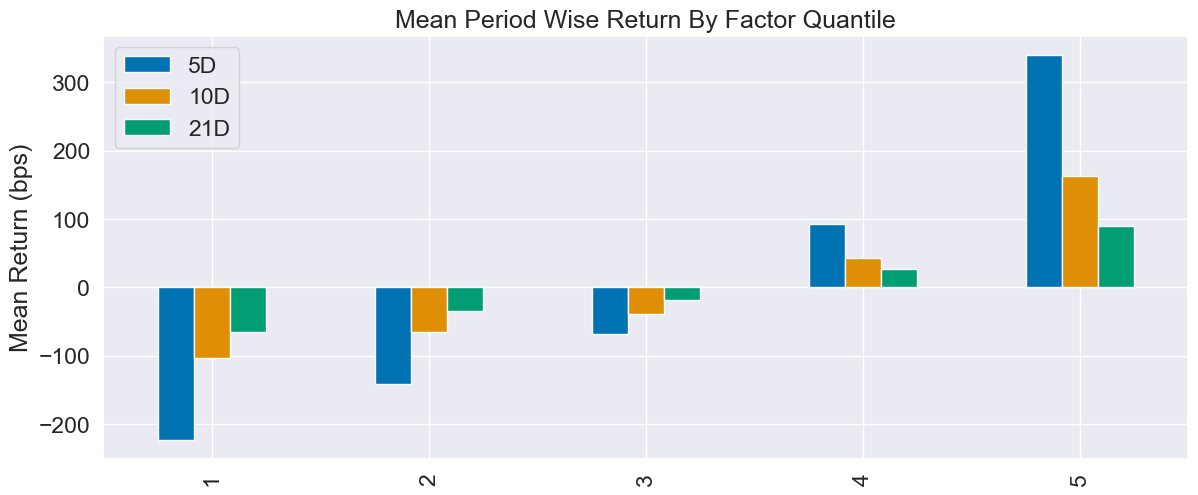

In [166]:
import warnings
warnings.filterwarnings('ignore')

create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.507620,0.268162,-0.657784,0.215718,10151,20.067214
2,-1.185615,0.425635,-0.497399,0.312712,10098,19.962439
3,-1.061077,0.642897,-0.354591,0.381362,10107,19.980231
4,-0.896839,0.832944,-0.164664,0.414543,10098,19.962439
5,-0.771365,1.330265,0.184175,0.387370,10131,20.027676


Returns Analysis


,5D,10D,21D
Ann. alpha,3.244,1.041,0.427
beta,0.122,0.055,0.086
Mean Period Wise Return Top Quantile (bps),340.371,162.614,89.794
Mean Period Wise Return Bottom Quantile (bps),-223.164,-103.708,-65.947
Mean Period Wise Spread (bps),563.535,266.366,155.541


<Figure size 640x480 with 0 Axes>

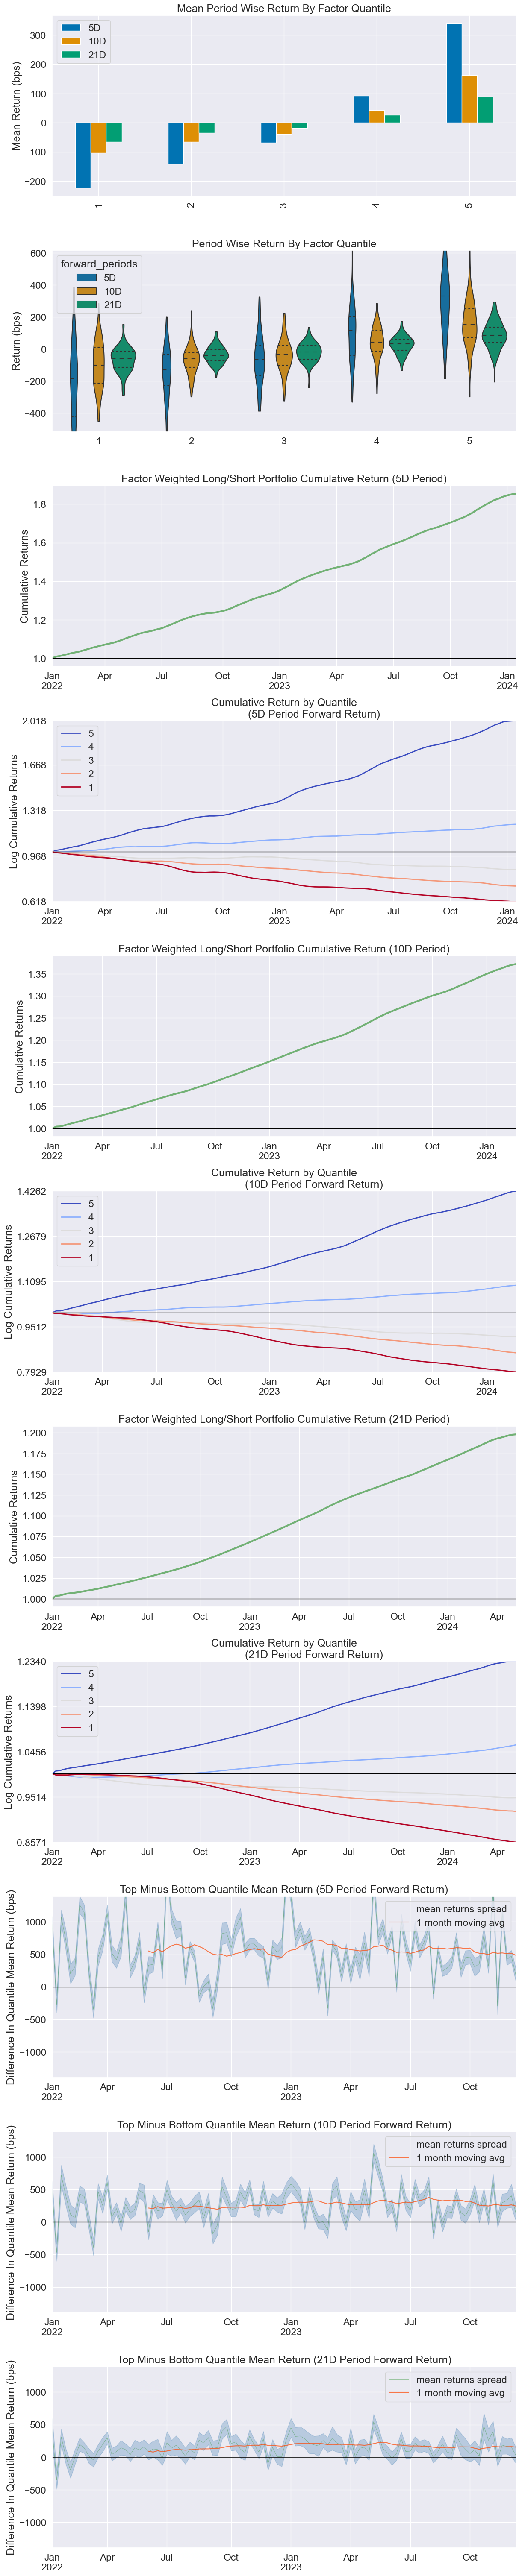

Information Analysis


,5D,10D,21D
IC Mean,0.248,0.170,0.135
IC Std.,0.185,0.145,0.121
Risk-Adjusted IC,1.341,1.172,1.114
t-stat(IC),13.545,11.841,11.251
p-value(IC),0.000,0.000,0.000
IC Skew,-0.168,-0.049,-0.087
IC Kurtosis,-0.255,0.540,0.849


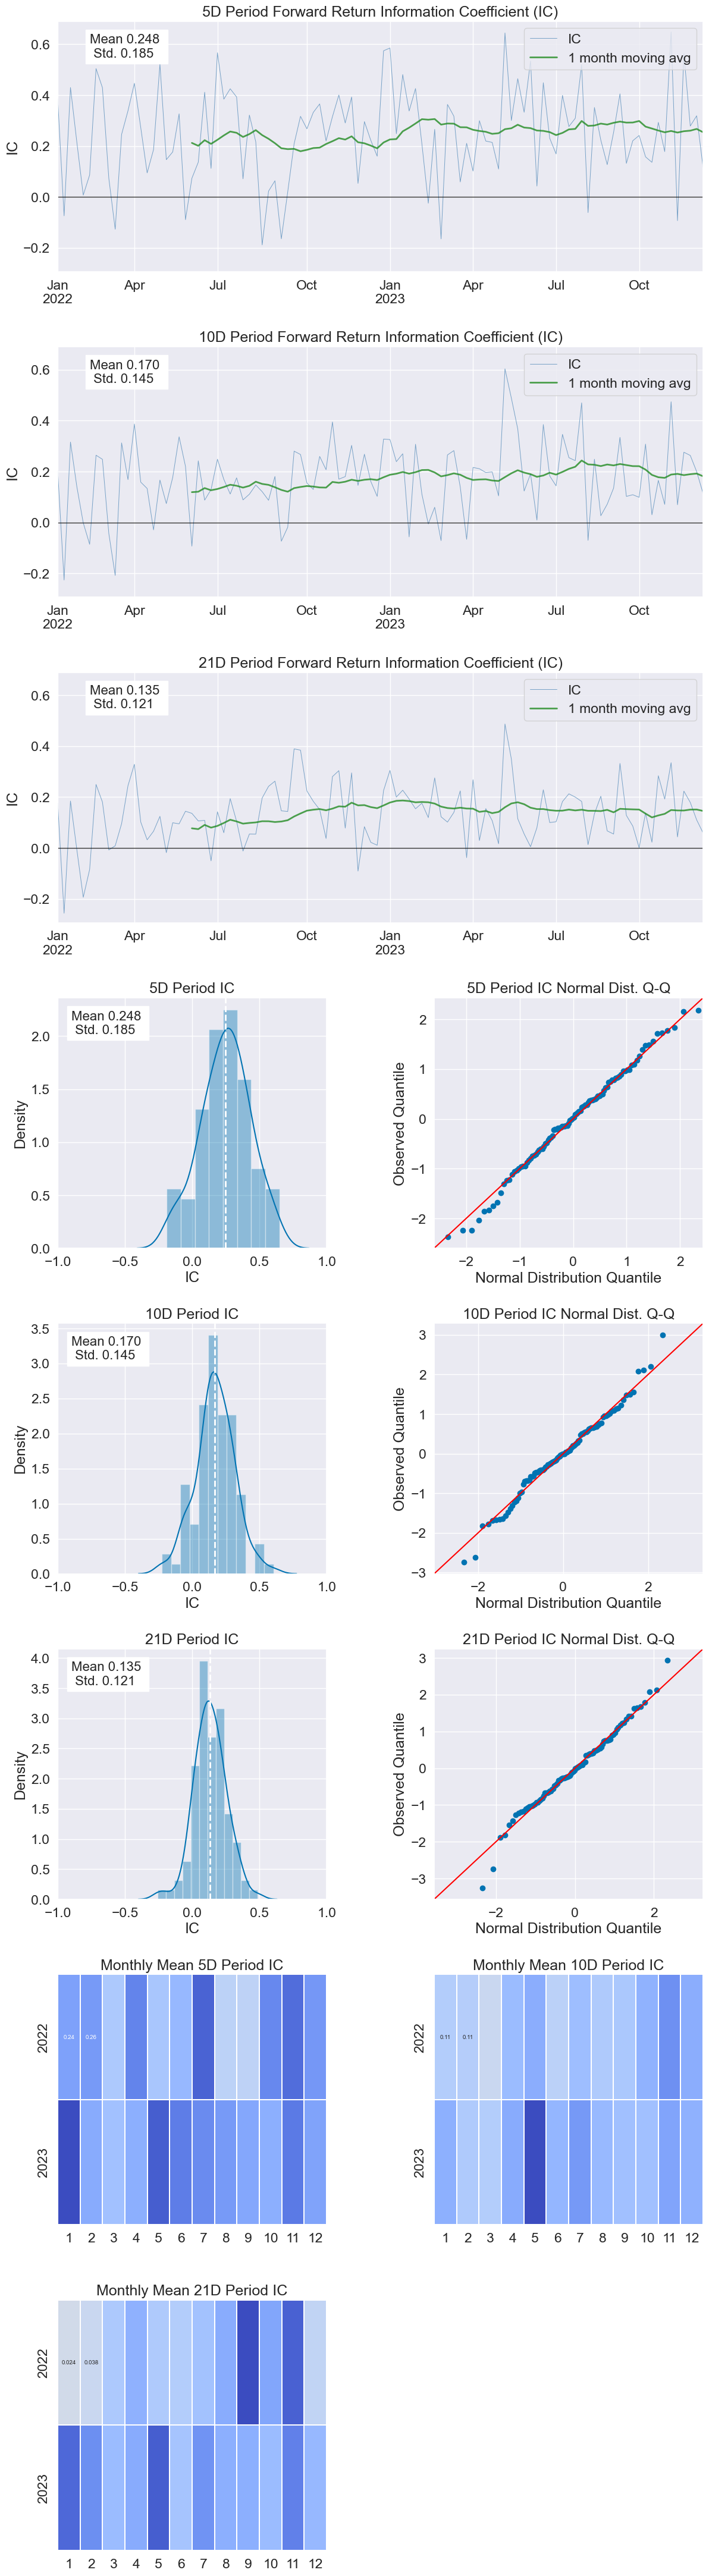

Turnover Analysis


,10D,21D,5D
Quantile 1 Mean Turnover,0.765,0.762,0.776
Quantile 2 Mean Turnover,0.791,0.799,0.780
Quantile 3 Mean Turnover,0.791,0.788,0.789
Quantile 4 Mean Turnover,0.797,0.790,0.796
Quantile 5 Mean Turnover,0.773,0.777,0.758


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.054,0.051,0.052


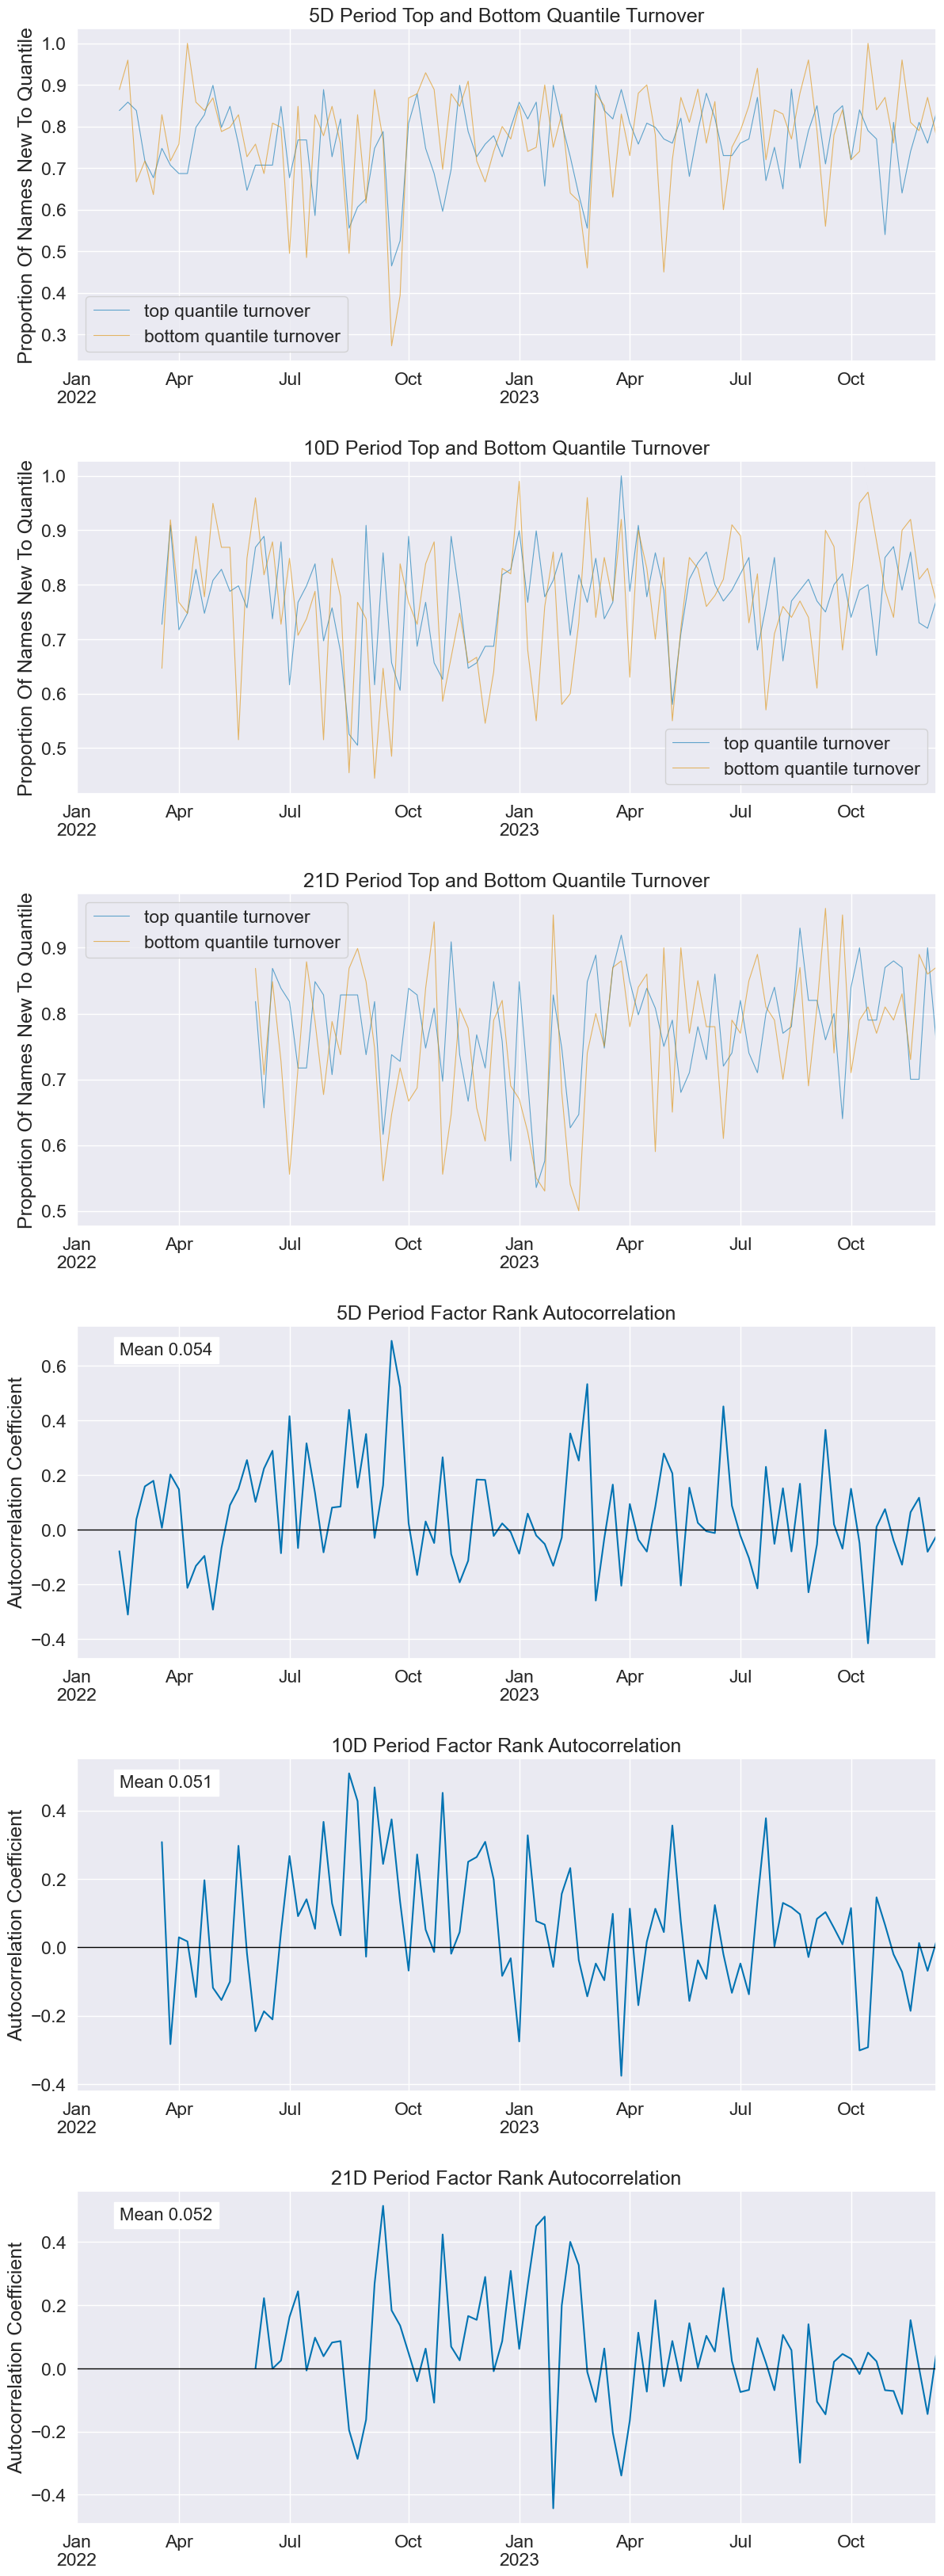

In [168]:
import warnings
warnings.filterwarnings('ignore')


create_full_tear_sheet(factor_data)